# SWOT EA Workshop, Part _#1_

>User notes:
>This notebook is developed as a standalone workflow -- it should work in your analysis environment provided that environment has...
>* Python 3.7+,
>* the standard Jupyter notebook server/client software, and
>* the power of the internet at its disposal.

## Getting Started 

### Earthdata Login

```python
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.earthdata.nasa.gov")

# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.earthdata.nasa.gov")
```

### Requirements

In [2]:
from glob import glob
from os.path import join, isfile, basename, abspath
from datetime import datetime
from folium.plugins import MarkerCluster
import folium
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import requests
import json
import time

matplotlib.rc('font', **{'family' : 'sans-serif', 'weight': 'normal', 'size': 16})

!mkdir -p resources/

### Study region and period

Set some "master" inputs to define the time and place contexts for our case studies in the ipynb. 

In [3]:
# The timeframe of interest (Argovis API limit == 3 months):
start_date = "2019-01-01"
end_date   = "2019-01-31"

# The area/region of interest by latitude/longitude:
aoi_minlon = -26.0
aoi_minlat = 30.0
aoi_maxlon = -12.0
aoi_maxlat = 40.0

Plot the spatial extent of our study area with a blue polygon:

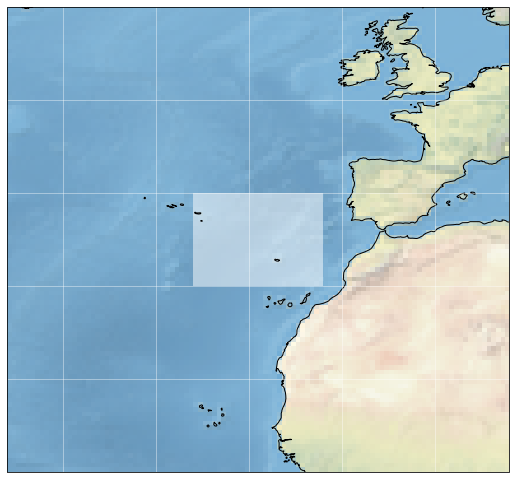

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

ax = plt.subplot(projection=ccrs.PlateCarree())
ax.figure.set_figheight(9)
ax.figure.set_figwidth(9)
ax.add_patch(mpatches.Rectangle(xy=[aoi_minlon, aoi_minlat], 
                                width=aoi_maxlon-aoi_minlon, 
                                height=aoi_maxlat-aoi_minlat,
                                facecolor='white',
                                alpha=0.5,
                                transform=ccrs.Geodetic())
             )
ax.set_extent((aoi_minlon-20., 
               aoi_maxlon+20.,
               aoi_minlat-20.,
               aoi_maxlat+20.), crs=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(color="white", alpha=0.5)
plt.show()

Plot a simple map with a bounding box showing the AOI:

```python
m = folium.Map(location=[35.0, -19.0], zoom_start=4)

folium.Polygon(locations=[[
        [aoi_minlat, aoi_minlon], 
        [aoi_minlat, aoi_maxlon], 
        [aoi_maxlat, aoi_maxlon],
        [aoi_maxlat, aoi_minlon],
        [aoi_minlat, aoi_minlon]
]]).add_to(m)

display(m)
```

## Get in situ temperature measurements from Argo profiles

### Access profiles from the ArgoVis API

ArgoVis is an API and visualization service that provides access to Argo float profiles. The endpoint for requesting profile data is given in the cell below:

In [7]:
argo_api_endpoint = 'https://argovis.colorado.edu/selection/profiles/?'

print(argo_api_endpoint)

https://argovis.colorado.edu/selection/profiles/?


>The argovis API requires the vertices for the input region (the *shape* parameter) to be given in 
*longitude,latitude* order reverse of the input plot the AOI using `folium.Polygon` in the cells above.

Create the AOI bounding polygon in the proper format and submit a request to the Argovis API:

In [8]:
argo_api_aoi = [[[aoi_minlon, aoi_minlat], 
                 [aoi_minlon, aoi_maxlat], 
                 [aoi_maxlon, aoi_maxlat],
                 [aoi_maxlon, aoi_minlat],
                 [aoi_minlon, aoi_minlat]]]

argo_api_params = {
    'startDate': start_date.replace("-0","-"),     # the 'startDate' and 'endDate' parameters
    'endDate': end_date.replace("-0","-"),         #  do not allow leading zeros
    'shape': str(argo_api_aoi).replace(" ",""),    # Submit array of vertices
    #'presRange': "[0,30]"                         # Limit results to pressure window
}

argo_api_params

{'startDate': '2019-1-1',
 'endDate': '2019-1-31',
 'shape': '[[[-26.0,30.0],[-26.0,40.0],[-12.0,40.0],[-12.0,30.0],[-26.0,30.0]]]'}

Submit the request to the Argovis API along with the properly formatted parameters, and you should receive a JSON response back if all goes well:

In [9]:
argo_api_response = requests.get(url=argo_api_endpoint, params=argo_api_params)

# Load the response from JSON if the response status is 200:
if argo_api_response.status_code == 200:
    argo_profiles = argo_api_response.json()
    print(len(argo_profiles))
else:
    # Otherwise dump the text for more clues:
    print(argo_api_response.text)

41


### Prepare profile data for further analysis

Concatenate the list of metadata dictionaries returned for the argos into a table and update a few of its columns with Pythonic types:

In [10]:
argo_df = pd.DataFrame(argo_profiles).sort_values("date")

# Add a column with pandas datetime objects for easier indexing
argo_df['datetime'] = pd.to_datetime(argo_df['date'])
# And then replace the original date column with Python dates
argo_df['date'] = argo_df.datetime.apply(lambda x: x.date).tolist()

# Add two columns of sanitized lats/lons to the data frame
argo_df['lat'] = argo_df['roundLat'].astype(float).tolist()
argo_df['lon'] = argo_df['roundLon'].astype(float).tolist()

argo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 40 to 0
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   _id                           41 non-null     object             
 1   POSITIONING_SYSTEM            41 non-null     object             
 2   DATA_CENTRE                   41 non-null     object             
 3   PI_NAME                       41 non-null     object             
 4   WMO_INST_TYPE                 41 non-null     object             
 5   VERTICAL_SAMPLING_SCHEME      41 non-null     object             
 6   DATA_MODE                     41 non-null     object             
 7   PLATFORM_TYPE                 41 non-null     object             
 8   measurements                  41 non-null     object             
 9   station_parameters            41 non-null     object             
 10  pres_max_for_TEMP             41 non-nul

You can download profiles in netCDF format from the FTP link stored in the *nc_url* fields of the response. Here's the URL for the first of the profiles:

In [11]:
print(argo_df.iloc[0].nc_url)

ftp://ftp.ifremer.fr/ifremer/argo/dac/coriolis/6902663/profiles/R6902663_124.nc


Display a table summarizing the space/time characteristics of eaach profile:

In [14]:
argo_df[['platform_number', 'cycle_number', 'datetime', 'lon', 'lat']] #, 'measurements']]

,platform_number,cycle_number,datetime,lon,lat
40,6902663,124,2019-01-01 20:14:00+00:00,-17.383,35.601
39,6901260,49,2019-01-02 05:43:00+00:00,-12.812,37.707
38,6901143,228,2019-01-02 09:22:20+00:00,-21.083,32.254
37,6902664,124,2019-01-02 20:28:00+00:00,-18.411,34.985
36,3901643,43,2019-01-04 06:13:00+00:00,-22.429,37.556
35,3901942,48,2019-01-05 20:23:30+00:00,-15.286,35.316
34,6901262,22,2019-01-06 05:42:59.999000+00:00,-17.967,34.228
33,3901932,22,2019-01-06 05:49:00+00:00,-19.904,33.428
32,1901688,288,2019-01-07 03:11:53+00:00,-23.134,34.258
31,6901260,50,2019-01-07 05:26:00+00:00,-12.887,37.905


*Now plot argo profile locations on an interactive map.*

This plot uses folium/leaflet. Hover/click the clusters (which correspond to specific Argo float platforms) to zoom to the groups of individual profiles and display metadata about them:

In [15]:
def _get_tooltip(profile: dict):
    return """<b>Date</b>: {date}<br>
              <b>Profile ID</b>: {_id}<br>
              <b>Platform ID</b>: {platform_number}<br>
              <b>Latitude</b>: {lat}<br>
              <b>Longitude</b>: {lon}<br>""".format(**profile)


m = folium.Map(location=[argo_df['lat'].mean(), argo_df['lon'].mean()], 
               tiles="Stamen Terrain",
               zoom_start=5, )

# Loop over list of unique platform_numbers (floats)
unique_argo_platform_numbers = argo_df.platform_number.unique().tolist()

for i, platform in enumerate(unique_argo_platform_numbers):
    # Get row(s) for the current platform
    p = argo_df[argo_df['platform_number']==platform]
    # Make an empty marker cluster to add to the map widget
    cluster = MarkerCluster(name=p['platform_number'])
    # Make markers in a loop and add to the cluster:
    for c in p['cycle_number'].tolist():
        # Select the row for the current profile ('cycle')
        profile = p[p['cycle_number']==c].iloc[0]
        # Create a new marker and add it to the cluster
        cluster.add_child(folium.Marker(
            location=[profile['lat'], profile['lon']],
            tooltip=_get_tooltip(profile.to_dict())))
    m.add_child(cluster)

display(m)

#### Reformat profile data into data frames

The in situ measurements temperature, pressure, and salinity readings collected during each profile are returned inside the JSON response.

The format of the *measurements* field is perfect for conversion to *pandas* data frames. Apply *pandas.DataFrame* over the entire measurements column to make a pandas.Series of data frames, and replace the existing content in the *measurements* column:

In [16]:
argo_df['measurements'] = argo_df['measurements'].apply(pd.DataFrame).tolist()

# Print statistical summary of the table content:
argo_df.iloc[0].measurements.describe()

,temp,pres,psal
count,105.000000,105.000000,105.000000
mean,11.579429,794.390476,35.832990
std,4.726514,655.512828,0.433002
min,4.053000,6.000000,35.073000
25%,8.096000,146.000000,35.597000
50%,10.885000,713.000000,35.765000
75%,15.750000,1363.000000,36.128000
max,18.418000,2010.000000,36.504000


**Plot the temperatures measured in the minimum pressure bin for each profile across all platforms**

This cell applies a lambda over the measurements column to slice the row corresponding to the minimum pressure bin for each profile and returns the corresponding temperature measurement:

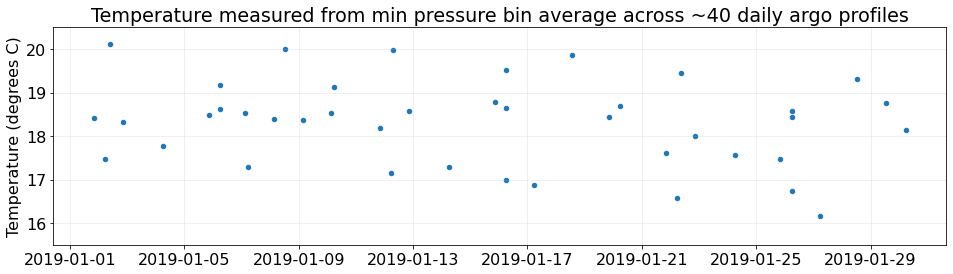

In [17]:
def _get_prof_temp_at_pres_min(x):
    return x[x['pres']==x['pres'].min()]['temp'].item()

# Apply the fuunction over the column of measurements tables
argo_df['temp_at_pres_min'] = argo_df['measurements'].apply(_get_prof_temp_at_pres_min).tolist()

# Plot temperature measured nearest to the sea surface for each profile 
argo_df.plot.scatter(x="datetime", y="temp_at_pres_min", figsize=(16, 4))
plt.title("Temperature measured from min pressure bin average across ~40 daily argo profiles")
plt.xlabel(None)
plt.ylabel("Temperature (degrees C)")
plt.ylim(15.5, 20.5)
plt.grid(alpha=0.25)

#### Select a target argo float by its *platform_number*

Find out which argo floats collected the most measurement profiles within our time period and location of interest.

In [18]:
argo_df.groupby("platform_number").count()['cycle_number']

platform_number
1901688    6
3901643    3
3901932    3
3901942    3
6901143    3
6901260    6
6901262    3
6901273    3
6902552    3
6902663    3
6902664    3
6902785    2
Name: cycle_number, dtype: int64

Choose one of the floats with six profiles as the focus of further study through the remainder of the notebook.

In [19]:
target_argo = 6901260

# Select profiles (rows) that correspond to the target platform:
argo_skinny = argo_df[argo_df.platform_number==target_argo].copy()

argo_skinny.describe()

,pres_max_for_TEMP,pres_min_for_TEMP,pres_max_for_PSAL,pres_min_for_PSAL,max_pres,date_qc,lat,lon,position_qc,cycle_number,platform_number,BASIN,temp_at_pres_min
count,6.000000,6.0,6.000000,6.0,6.000000,6.0,6.000000,6.000000,6.0,6.000000,6.0,6.0,6.000000
mean,1992.666667,6.0,1992.666667,6.0,1992.666667,1.0,38.131167,-13.030667,1.0,51.500000,6901260.0,1.0,16.921000
std,21.500388,0.0,21.500388,0.0,21.500388,0.0,0.297238,0.168997,0.0,1.870829,0.0,0.0,0.495337
min,1961.000000,6.0,1961.000000,6.0,1961.000000,1.0,37.707000,-13.265000,1.0,49.000000,6901260.0,1.0,16.153000
25%,1980.500000,6.0,1980.500000,6.0,1980.500000,1.0,37.940500,-13.132500,1.0,50.250000,6901260.0,1.0,16.643250
50%,1994.500000,6.0,1994.500000,6.0,1994.500000,1.0,38.156500,-13.037000,1.0,51.500000,6901260.0,1.0,17.014000
75%,2010.750000,6.0,2010.750000,6.0,2010.750000,1.0,38.350000,-12.910750,1.0,52.750000,6901260.0,1.0,17.263250
max,2014.000000,6.0,2014.000000,6.0,2014.000000,1.0,38.484000,-12.812000,1.0,54.000000,6901260.0,1.0,17.479000


## Get coincident sea surface temperature observed by MODIS

We'll request subsets of L2 MODIS SST from GHRSST for the region encompassing the spatial coverage of the new *argo_skinny* data frame. (It follows the trajectory of one argo float during the month of January in 2019.)

Get the bounding coordinates and redefine our area of interest:

In [20]:
aoi_minlon = argo_skinny.lon.min()
aoi_maxlon = argo_skinny.lon.max()
aoi_minlat = argo_skinny.lat.min()
aoi_maxlat = argo_skinny.lat.max()

aoi_minlon, aoi_minlat, aoi_maxlon, aoi_maxlat

(-13.265, 37.707, -12.812, 38.484)

Here's the user guide for L2 MODIS SST from GHRSST for your reference: https://podaac-tools.jpl.nasa.gov/drive/files/OceanTemperature/ghrsst/docs/GDS20r5.pdf

**Search CMR to obtain information required for the Harmony API**

We require a sorta cryptic dataset identifier in order to request subsets of the MODIS data. In the cell below, I submit a request to the CMR API to retrieve the metadata corresponding to the dataset/collection.

In [21]:
modis_results = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': "MODIS_A-JPL-L2P-v2019.0",
            'token': token}
).json()

# Select the first and only record from the JSON response:
modis_coll = modis_results['items'][0]

# Select the concept-id for the dataset/collection from its metadata:
modis_ccid = modis_coll['meta']['concept-id']

modis_ccid

'C1940473819-POCLOUD'

### Request L2 MODIS SST subsets from the Harmony API

How we'll request a time series of MODIS data subset to the coverage defined just above and covering the period from January 1 to January 31 2019. To do that, we must learn how to use the [Harmony API](https://harmony.earthdata.nasa.gov/)! (I think you'll find it very convenient.)

><u>Important note for new users</u>:<br>The API is under active development, and it's therefore recommended that you test your input parameters in the [Swagger API interface](https://harmony.earthdata.nasa.gov/docs/api/#).

#### Identify the request endpoint and appropriate request parameters

This next cell joins the Harmony API base url with the *modis_ccid* that we identified above, then appends the remainder of the url to get the target API endpoint. Run the cell and it should print the full url for your confirmation:

In [22]:
harmony_url = "https://harmony.earthdata.nasa.gov"
harmony_url_modis = f"{harmony_url}/{modis_ccid}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?"

print(harmony_url_modis)

https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?


Make a dictionary of subset parameters and format the values to meet requirements of the Harmony API. (See the Swagger UI linked above for more information about those requirements.)

We should expect our request for the full month to return at least 50 granule results. The API has a limit of 200 granules to be processed per request. So let's play it safe by requesting only the first 15 days of January 2019. (*Note how I've commented out the `time` subset parameter that we'd use to request the remaining 15 days in January.*)

In [24]:
harmony_params_modis = {
    'time': f'("{start_date}T00:00:00.000Z":"2019-01-15T23:59:59.999Z")',
    #'time': f'("2019-01-16T00:00:00.000Z":"{end_date}T23:59:59.999Z")',
    'lat': f'({aoi_minlat}:{aoi_maxlat})',
    'lon': f'({aoi_minlon}:{aoi_maxlon})',
}

harmony_params_modis

{'time': '("2019-01-01T00:00:00.000Z":"2019-01-15T23:59:59.999Z")',
 'lat': '(37.707:38.484)',
 'lon': '(-13.265:-12.812)'}

In [25]:
request_url_modis = harmony_url_modis+"subset=time{time}&subset=lat{lat}&subset=lon{lon}".format(**harmony_params_modis)

print(request_url_modis)

https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time("2019-01-01T00:00:00.000Z":"2019-01-15T23:59:59.999Z")&subset=lat(37.707:38.484)&subset=lon(-13.265:-12.812)


#### Submit the request parameters to the Harmony API endpoint

In Python, we use `requests` (or another HTTPS interface( to submit our parameters to the API as a GET request (there's also a POST option available in Harmony API). 

<u>Modify the cell below (or don't) depending on how you want to proceed.</u>

I've already submitted the two requests required to obtain full coverage for our region and timeframe of interest. They are referenced in the list *job_status* in the cell below. To resubmit the request, or to submit one of your own with different parameters, comment out the two items in the list like this:

```python
job_status = [
    #'https://...'
    #'https://...
]
```

The comments will cause the list to be considered empty by the Python interpreter, and will trigger new requests. 

In [26]:
job_status = [    
    "https://harmony.earthdata.nasa.gov/jobs/512ca343-3bfe-48c5-a480-9281b7348761",  # First time slice
    "https://harmony.earthdata.nasa.gov/jobs/5b29414d-3856-4e94-9568-01b32b02a951",  # Second time slice
]

If you've configured the cell above to set `job_status` as an empty list, then the following cell should submit a new request to the Harmony API.

If you *haven't* modified the cell above, then thi next cell should download a JSON from the url in position one. (It's in the same format as the JSON response that's returned when you submit a new request. We'll inspect this JSON status object in subsequent cells.)

In [27]:
if len(job_status)==0:
    # Submit the request and decode the response from json string to dict:
    response_modis = requests.get(request_url_modis)
    # If the response came back with something other than '2xx', raise an error:
    if not response_modis.status_code // 100 == 2: 
        raise Exception(response_modis.text)
    else:
        response_data = response_modis.json()
    # Append the status endpoint to the list of 'job_status' urls:
    job_status.append(response_data['links'][0]['href'])
else:
    response_data = requests.get(job_status[0]).json()
    
# Dump keys of the dictionary loaded from JSON string:
list(response_data.keys())

['username',
 'status',
 'message',
 'progress',
 'createdAt',
 'updatedAt',
 'links',
 'request',
 'numInputGranules',
 'jobID']

*To process new subsets covering the full month of January, you will need to run the cell above one more time to submit a request for days of the year 016-031.*

Successful requests to the API will respond with a JSON that starts like this:

```json
{
  "username": "jmcnelis",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2021-02-25T02:09:35.972Z",
  "updatedAt": "2021-02-25T02:09:35.972Z",
    ...
```

The example above is truncated to the first several lines for the sake of space. It also contains the originating request (the complete url printed a few cells above), the number of granules selected for processing with your request, and a unique job identifier (`jobID`, which provides the tail of the status url from which we downloaded the JSON).

**Monitor the status of in-progress jobs**

Select the `status` URL from the JSON response's list of `links` -- there should only be one item in the list if this is a new request. If you're accessing the JSON for an old request, this cell simply demonstrates how to retrieve the *job status* link that we've already hard-coded in the list called `job_status`.

Run the cell below to proceed in a way that accomodates both options:

In [28]:
if len(job_status)==0:
    try:
        job_status = [l['href'] for l in response_data['links'] if l['title']=="Job Status"]
    except (KeyError, IndexError) as e:
        raise e

print(job_status)

['https://harmony.earthdata.nasa.gov/jobs/512ca343-3bfe-48c5-a480-9281b7348761', 'https://harmony.earthdata.nasa.gov/jobs/5b29414d-3856-4e94-9568-01b32b02a951']


(If you *haven't* submitted a new request, then the cell above should have printed two urls -- they correspond to my preprocessed subset requests. If you *have* submitted a new request, the URL printed above should correspond to the unique job status endpoint for your new request.)

Run the next cell to monitor the status of as many requests as you need. It will loop over the `job_status` list and wait for all the requests to finish processing. (It terminates when the `status` field of the JSON response _does not_ contain the string `"running"`.)

In [29]:
wait = 10       # The number of seconds to wait between each status check
completed = {}  # A dict of JSON responses for completed jobs

# Loop repeatedly to check job status. Wait before retrying.
while True:
    for j in job_status:
        # Iterate over list of job status urls; skip if completed.
        if j in completed:
            continue
        # Get the current job's status as a JSON object.
        job_data = requests.get(j).json()
        if job_data['status']!='running':
            completed[j] = job_data  # Add to 'completed' if finished
    # Break loop if 'completed' dictionary contains all jobs.
    if len(completed)==2:
        break
    # If still processing, print a status update and wait ten seconds.
    print(f"# Job(s) in progress ({len(completed)}/{len(job_status)})")
    time.sleep(wait)
    
print(f"\n{'%'*40}\n%\t\tDONE!\n{'%'*40}\n")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%		DONE!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



The final JSON response downloaded from each _job_status_ url can be mammoth depending on the number of granules that were processed to complete your request. The largest object within the JSON is the list of `links`. 

Here I print the final JSON response from the first job status url, excluding the list of `links` for your information. (We'll go over the links in a moment.)

In [30]:
print(json.dumps({k:v for k, v in job_data.items() if k!="links"}, indent=2))

{
  "username": "jmcnelis",
  "status": "successful",
  "message": "The job has completed successfully",
  "progress": 100,
  "createdAt": "2021-03-01T21:40:56.233Z",
  "updatedAt": "2021-03-01T21:42:59.337Z",
  "request": "https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=time(%222019-01-16T00%3A00%3A00.000Z%22%3A%222019-01-31T23%3A59%3A59.999Z%22)&subset=lat(37.707%3A38.484)&subset=lon(-13.265%3A-12.812)",
  "numInputGranules": 55,
  "jobID": "5b29414d-3856-4e94-9568-01b32b02a951"
}


We'll move on to select the url for each link object during the next cell. For the sake of clarity, this cell prints the entire object for the first link (that corresponds to a netCDF subset -- those links should start at item _#2_):

In [31]:
print(json.dumps(job_data['links'][2], indent=2))

{
  "href": "https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/56d7a026-a935-46f4-8dc0-a645831aed84/20190116023001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4",
  "title": "20190116023001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4",
  "type": "application/x-netcdf4",
  "rel": "data",
  "bbox": [
    -13.3,
    37.7,
    -12.8,
    38.5
  ],
  "temporal": {
    "start": "2019-01-16T02:30:01.000Z",
    "end": "2019-01-16T02:34:59.000Z"
  }
}


#### Subset request outputs

The list of `links` (one per submitted request) is the most important part of the output. They provide the urls where we can access the subsets after they've been processed and staged for us in S3.

The first two links point to resources that don't contain any actual data. The first is the request status endpoint (the same one that we used just now to obtain this JSON and list of links) and the second is a [STAC Catalog](https://stacspec.org/). STAC Catalogs provide the metadata to compatible softwares that allow the user to systematically process diverse remote datasets through a common analysis framework. (See the STAC documentation for more information.)

Both of those can be ignored for the purposes of this demonstration workflow. This cell merges the lists for our two jobs and selects just the urls for the output netCDF files. Run the cell and the total number of subset links (netCDF4  files only) should be printed below:

In [32]:
job_links = []

for j in list(completed.values()):
    for l in j['links']:
        if l['href'].endswith("subsetted.nc4"):
            job_links.append(l)

print(len(job_links))

74


### Prepare subset data for further analysis

Get the subsets and key metadata as `pandas.DataFrame`. We'll use the convenient *apply* logic to calculate statistics over our subsets in a few subsequent steps. Print the size of the data frame (row-wise) afterwards to confirm:

In [33]:
subsets_df = pd.DataFrame(data=[{**l, **l['temporal']} for l in job_links])

print(subsets_df.index.size)

74




Add a day/night flag column to the table by applying a simple lambda over the `href` column. It checks the source granule's filename for a string that indicates whether the swath was acquired at night or during the daytime.

In [34]:
subsets_df['daytime'] = subsets_df['href'].apply(lambda x: 'MODIS_A-N' not in x)

subsets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   href      74 non-null     object
 1   title     74 non-null     object
 2   type      74 non-null     object
 3   rel       74 non-null     object
 4   bbox      74 non-null     object
 5   temporal  74 non-null     object
 6   start     74 non-null     object
 7   end       74 non-null     object
 8   daytime   74 non-null     bool  
dtypes: bool(1), object(8)
memory usage: 4.8+ KB


And finally, reformat the *start* timestamps as a new column containing pandas datetime objects instead of strings. Then, add one more column containing a date object (rather than the full datetime timestamp) which we'll use to aggregate the data before plotting.

In [35]:
# Add new 'datetime' column so that we aren't working with strings:
subsets_df['datetime'] = pd.to_datetime(subsets_df['start'])

# Add new 'date' column for aggregation during the final steps of the workflow:
subsets_df['date'] = subsets_df.datetime.apply(lambda x: x.date()).tolist()

subsets_df.date.iloc[0]

datetime.date(2019, 1, 1)

Now map the coverages of the subsets using their bounding boxes, which we received as part of each link object:

In [36]:
# Use numpy wizardy to get arrays of bbox coordinates for all subsets:
minlons, minlats, maxlons, maxlats = np.array(subsets_df.bbox.tolist()).T


def _get_coverage_tooltip(s: dict):
    content = []
    for k, v in s.items():
        if k not in ['href', 'temporal']:
            content.append(f"<b>{k}</b>: {v}")
    return f"<p>{'<br>'.join(content)}</p>"


def _map_coverage_Polygon(subset, map_object):
    # Get the subset bbox components as four separate python variables:
    xmin, ymin, xmax, ymax = subset['bbox']
    # Return a Polygon object with embedded metadata about the subset:
    folium.Polygon(
        # Arrange bbox components in a closed vector:
        locations=[[[ymin, xmin], [ymin, xmax], [ymax, xmax], [ymax, xmin], [ymin, xmin]]],
        # Call function defined above to get a tooltip:
        tooltip=_get_coverage_tooltip(subset)
    # Call 'add_to' method to plot it on the map:
    ).add_to(map_object)


# Create a new folium map instance
m = folium.Map(location=[(minlats.min()+maxlats.max())/2, 
                         (minlons.min()+maxlons.max())/2], zoom_start=7)

# Iterate and map the spatial coverages:
for ix, row in subsets_df.iterrows():
    _map_coverage_Polygon(subset=row.to_dict(), map_object=m)


display(m)

The bounding boxes can help with understanding how the service select the appropriate granules for subsetting. Any granule that spatially intersects your input vector will be subset and staged for output *up to 200 granules*.

### Accessing outputs from your subset request

First we'll download all of them to local disk (or our cloud storage, if we're working inside AWS). Set the target directory and we'll download the subsets into the current workspace:

In [37]:
target_dir = f"resources/data/"

!mkdir -p $target_dir

Define a function to handle the downloads reliably. Then, test by downloading the first subset output from our table *subsets_df*:

In [40]:
def download_target_file(url: str, force: bool=False):
    # Determine the target path for the download
    target_file = join(target_dir, basename(url))
    if isfile(target_file) and force is False:
        print(f"# File already exists. Skipping...\n({basename(url)})\n")
        return
    print(f"# File downloading...\n({basename(url)})\n")
    # Open a remote connection for download stream/write to disk:
    with requests.get(url) as r:
        # Raise exception if response has status other than '2xx':
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
        else:
            # Otherwise write the file to disk:
            with open(target_file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
                        

# Test the download function by passing the URL for the first subset in the `subsets` table:
download_target_file(url=subsets_df['href'].iloc[0])

# Join the string path to the target file that should have just downloaded.
test_nc4 = join(target_dir, basename(subsets_df['href'].iloc[0]))

print("The first file downloaded successfully:", isfile(test_nc4))

# File already exists. Skipping...
(20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

The first file downloaded successfully: True


Double-check by making sure that *ncdump* can print the header of the downloaded netCDF file. (I truncated the output below to just the first 20 lines for brevity.) The cell below calls the *ncdump* command line utility using an IPython magic operator `!` that executes the current line of code from the shell (instead of the Python client).

In [41]:
!ncdump -h $test_nc4 | head -20

netcdf \20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted {
dimensions:
	nj = 92 ;
	ni = 42 ;
	time = 1 ;
variables:
	float lat(nj, ni) ;
		lat:_FillValue = -999.f ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:valid_min = -90.f ;
		lat:valid_max = 90.f ;
		lat:comment = "geographical coordinates, WGS84 projection" ;
		lat:coverage_content_type = "coordinate" ;
	float lon(nj, ni) ;
		lon:_FillValue = -999.f ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;


(A netCDF file format error indicates that your download was not successful. Try to *cat* the file content for more clues as to why.)

Triple confirm the successful download by reading the *sea_surface_temperature* variable and plotting the grid:

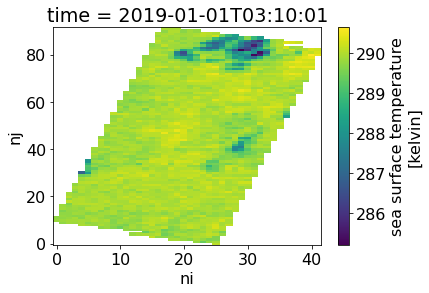

In [42]:
with xr.open_dataset(test_nc4) as ds:
    ds.sea_surface_temperature[0].plot()

#### Download the subsets

I started by coding up a little concurrency routine to manage the downloads over multiple simultaneous connections. That's a bit out of scope for the notebook, so it's not run in this example. But it's copied below for your future reference.

<u>Download remaining subsets to local disk (concurrent)</u>

Get the number of cores available on the host, which determines the max concurrent downloads:

```python
num_cores = multiprocessing.cpu_count()

print(f"# Download jobs will be processed between {num_cores} workers")

```

Now you could submit the list of urls to a concurrent download routine and monitor the status:

```python
# Get the column of links/urls as a list
downloads = subsets['href'].tolist()

with ProcessPoolExecutor(max_workers=num_cores) as pool:
    with tqdm(total=len(downloads)) as progress:
        futures = []
        for u in downloads:
            future = pool.submit(download_target_file, u)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)
        results = []
        for future in futures:
            result = future.result()
            results.append(result)
```

<u>Download remaining subsets to local disk (serial)</u>

Get the column of links/urls as a list and then download in a loop:

In [43]:
for u in subsets_df['href'].tolist():
    download_target_file(u)

# File already exists. Skipping...
(20190101031001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190101141501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190102021501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190102132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190103030000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190103140501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190104020501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190104034001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0_subsetted.nc4)

# File already exists. Skipping...
(20190104034501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0

Check the contents of the *target_dir*. Assemble absolute paths in a new column for reliable access by downstream processes:

In [44]:
subsets_df['path'] = subsets_df['href'].apply(lambda x: abspath(join(target_dir, basename(x))))

isfile(subsets_df['path'].iloc[0])

True

## Analyze *sea surface temperature* from both sources

Now let's look at the MODIS SST observations and the in situ measurements from the Argo profiles side-by-side.

Start by selecting just the *daytime* observations into a new data frame. (Remember we added the *daytime* column a short while ago.)

In [45]:
subsets_day = subsets_df[subsets_df.daytime==True].copy()

print(subsets_day.index.size, "of", subsets_df.index.size, "MODIS acquisitions were collected during daytime")

37 of 74 MODIS acquisitions were collected during daytime


The selection to exclude MODIS nighttime observations changed the start of our time series. In the next cell, we'll plot the first timestep's subset just as we did before but with a quality mask/filter applied.

#### Data quality

The *quality_level* variable describes the observation for pixel as one of the following:

1. no_data
2. bad_data
3. worst_quality
4. low_quality
5. acceptable_quality
6. best_quality

We'll use these flags to reduec the uncertainty in the time series of means calculated that we're about to calculate for L2 MODIS sea surface temperature. In the next cell, plot the first timestep after masking out the pixels that are not acceptable or best quality.

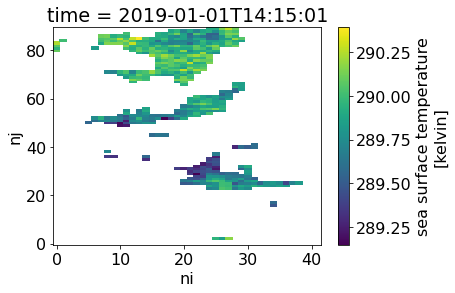

In [46]:
with xr.open_dataset(subsets_day.iloc[0].path) as ds:

    # Create a mask for pixels that are 
    quality_mask = ds.quality_level[0]>=4  #==5

    # Fill pixels where ###### with np.nan:
    masked_ds = ds.where(quality_mask)

    # Plot the resulting array of sea surface temperature:
    masked_ds.sea_surface_temperature[0].plot()

### Calculate and plot a time series of means

Now let's roll all the logic above into a few map-able functions. We want to systematically summarize our data along the same time axis (dates, actually). To do that, we group the SST data points from each source (MODIS and Argos) by their respective *date* columns and calculate the average for the whole date/timestep as one value.

#### Convenience functions apply filter and compute mean of L2 MODIS SST 

`get_user_stat` reads the input netCDF and applies some user-specified function to the dataset to render the desired output, then closes the file.

The second function `_masked_mean` is the *user statistic* that I referred to just now. It should take an opened xarray dataset as the sole input from which to render my desired output for the corresponding step in the time series. As previously mentioned, we get the output by calculating the mean for the XY dimensions of the MODIS subsets. 

*Consider `_masked_mean` to be a dummy function. You can put whatever you like in its place to compute your desired output(s) over your subset time series.*

In [50]:
subsets_day['path'].iloc[0]

'/home/ubuntu/workspace/swotea/resources/data/20190101141501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4'

In [51]:
def get_user_stat(netcdf, function):
    with xr.open_dataset(netcdf) as ds:  
        output = function(ds)
    return output


def _masked_mean(ds):
    '''Produce any output stat/object you want in this function'''
    # Create a mask for pixels that are 
    quality_mask = ds.quality_level[0]>=5
    # Fill pixels with np.nan where quality_level is less than 4:
    masked_ds = ds.where(quality_mask)
    # Calculate mean over the XY dimensions (nj,ni in this case)
    value = masked_ds['sea_surface_temperature'].mean(["nj", "ni"]).data.item()
    return value


val = get_user_stat(subsets_day['path'].iloc[0], function=_masked_mean)

val-273.15  # subtract 273.15 to convert Kelvin to Celsius

16.743005371093773

#### Calculate statistics for each MODIS SST subset as a new column

Now apply the `_masked_mean` function over the column of subsets (i.e. netCDF4 files) to calculate the mean of the unmasked pixels at each step in the time series of MODIS subsets:

In [52]:
subsets_day['sst_mean'] = subsets_day['path'].apply(get_user_stat, args=(_masked_mean,))-273.15

subsets_day['sst_mean'].describe()

count    15.000000
mean     16.404915
std       0.566561
min      15.284357
25%      15.921838
50%      16.546533
75%      16.833688
max      17.222162
Name: sst_mean, dtype: float64

#### Aggregate by *date* and compute the final time series of means

Group by date and calculate the mean of groups timesteps for each day of MODIS subsets:

In [55]:
subsets_day_means = subsets_day.groupby("date", as_index=False).mean("date")

subsets_day_means.describe()

,sst_mean
count,15.000000
mean,16.404915
std,0.566561
min,15.284357
25%,15.921838
50%,16.546533
75%,16.833688
max,17.222162


#### Plot the SST time series from MODIS and from the Argo in situ measurements

Now plot the two time series along the same *date* axis and do visual comparison:

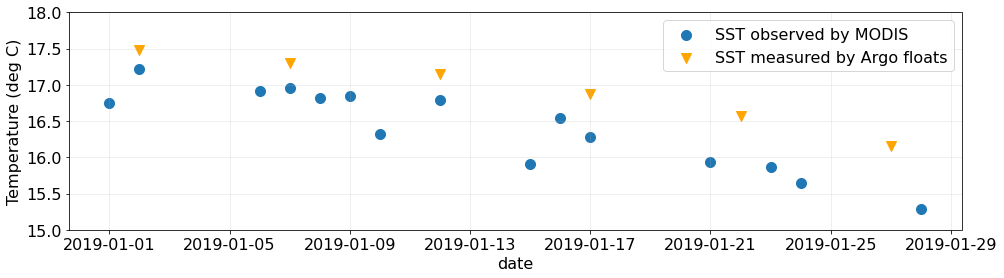

In [56]:
fig, ax = plt.subplots(figsize=(16, 4))

# Plot mean sea surface temperature from MODIS SST from GHRSST
subsets_day_means.plot.scatter(
    x="date",
    y="sst_mean", 
    label="SST observed by MODIS",
    s=100,
    ax=ax
)

# Plot mean sea surface temperature from the Argo floats
argo_skinny.plot.scatter(
    x="date",
    y="temp_at_pres_min",
    s=100,
    color="orange",
    marker="v",
    label="SST measured by Argo floats",
    ax=ax
)

# Matplotlib aesthetic treatments starting from here -->
ax.set_ylabel("Temperature (deg C)")
ax.set_ylim(15.0, 18.0)
ax.grid(alpha=0.25)

### MUR Level 4 SST from the AWS Open Data Registry

Now let's validate again by plotting our data against the MUR L4 sea surface temperature time series from the AWS Open Data Registry: https://registry.opendata.aws/mur/

In [57]:
import fsspec
import xarray as xr
from dask.distributed import Client

# Reference the MUR L4 SST data on the AWS Open Data Registry
url = 's3://mur-sst/zarr'

# Open the remote dataset from its S3 endpoint (pre-consolidated)
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)

# Slice the dataset along its X, Y, and T dimensions:
mur_L4_subset = ds['analysed_sst'].sel(
    time=slice('2019-01-01','2019-01-31'),
    lat=slice(aoi_minlat, aoi_maxlat), 
    lon=slice(aoi_minlon, aoi_maxlon),
).persist()

# Aggregate the spatial dimensions to compute the one-dimensional time series of means:
mur_L4_subset_means = mur_L4_subset.groupby("time").mean(["lon", "lat"])-273.15

print(mur_L4_subset_means)

<xarray.DataArray 'analysed_sst' (time: 31)>
dask.array<sub, shape=(31,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-31T09:00:00


Add the MUR time series to the subsets table so that they share the same time axis with the L2 time series:

In [58]:
subsets_day_means['L4_MUR_SST'] = mur_L4_subset_means.compute().data

Plot the result alongside our data processed throughout the notebook:

Text(0.5, 1.0, 'Daily SST from L2 MODIS, L4 MUR, and in situ measurements (January 2019)')

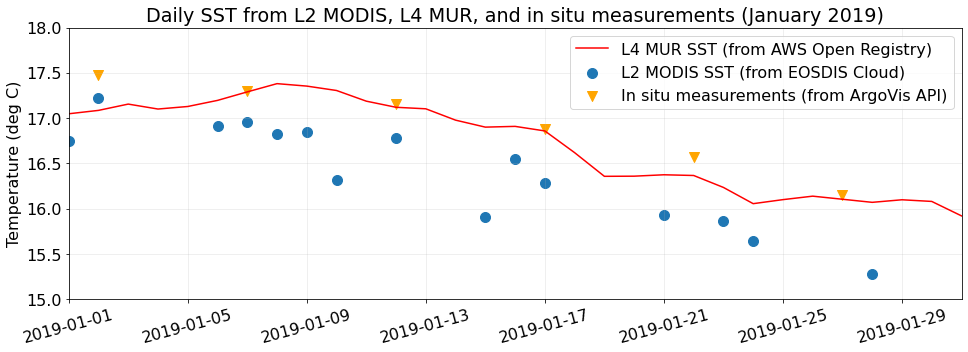

In [59]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot the L4 SST from MUR (hosted by AWS Open Registry)
subsets_day_means.plot.line(
    x="date",
    y="L4_MUR_SST",
    color="red",
    label="L4 MUR SST (from AWS Open Registry)",
    ax=ax,
)

# Plot the L2 SST from GHRSST (subset through Harmony API)
subsets_day_means.plot.scatter(
    x="date",
    y="sst_mean", 
    label="L2 MODIS SST (from EOSDIS Cloud)",
    s=100,
    ax=ax
)

# Plot the in situ temps measured at the surface during Argo profiles (accessed from ArgoVis)
argo_skinny.plot.scatter(
    x="date",
    y="temp_at_pres_min",
    s=100,
    color="orange",
    marker="v",
    label="In situ measurements (from ArgoVis API)",
    ax=ax
)

# Matplotlib aesthetic treatments starting from here -->
plt.xticks(rotation=15)
ax.set_xlabel(None)
ax.set_xlim(subsets_day_means.date.iloc[0], subsets_day_means.date.iloc[-1])
ax.set_ylabel("Temperature (deg C)")
ax.set_ylim(15.0, 18.0)
ax.grid(alpha=0.25)
ax.set_title("Daily SST from L2 MODIS, L4 MUR, and in situ measurements (January 2019)")

# ECCO

https://ecco-v4-python-tutorial.readthedocs.io/

In [ ]:
import sys
sys.path.append('/home/ubuntu/workspace/resources/ECCOv4-py')
import ecco_v4_py as ecco

In [ ]:
!pwd

In [ ]:
"ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4"